In [1]:
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models, datasets, transforms
from torch.utils.data import Dataset

In [3]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import splitfolders as sf
pathratio = Path('/content/drive/MyDrive/AlzheimerDetection/Alzheimer_s Dataset/train')
sf.ratio(pathratio,'output', ratio=(0.8,0.2,0.0), seed=42)

Copying files: 5121 files [01:27, 58.60 files/s] 


In [5]:
# Distribution of classes in train dataset
from glob import glob
from collections import Counter

def splitty(fny):
  return fny.split('/')[-2:]

x = glob('output/train/*/*')
y = [splitty(z) for z in x]

Counter([d[0] for d in y])

Counter({'VeryMildDemented': 1433,
         'ModerateDemented': 41,
         'MildDemented': 573,
         'NonDemented': 2048})

In [6]:
# Distribution of classes in validation dataset
from glob import glob
from collections import Counter

def splitty(fny):
  return fny.split('/')[-2:]

x = glob('output/val/*/*')
y = [splitty(z) for z in x]

Counter([d[0] for d in y])

Counter({'VeryMildDemented': 358,
         'ModerateDemented': 10,
         'MildDemented': 143,
         'NonDemented': 512})

In [ ]:
from glob import glob
from collections import Counter

def splitty(fny):
  return fny.split('/')[-2:]

x = glob('output/test/*/*')
y = [splitty(z) for z in x]

Counter([d[0] for d in y])

Counter({'VeryMildDemented': 1, 'ModerateDemented': 1, 'MildDemented': 1})

##### Creating transforms for training and validation/testing

In [7]:
tfms =  {
    'train': transforms.Compose([transforms.CenterCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ColorJitter(0.1,0.1,0.1,0.1),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
                                 ]),
         'val': transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))])}


In [8]:
import os
img_datasets = {x: datasets.ImageFolder(os.path.join('./output',x), tfms[x])
                for x in ['train','val']}

In [9]:
img_datasets['train'][3483][1]

3

#### Code to help balance out the dataset as there are too few positive moderate alzheimer cases

In [ ]:
# Refer: https://discuss.pytorch.org/t/imbalanced-class-augmentation-problem/144135

def get_sampler(target):
  class_sample_count = np.unique(target, return_counts=True)[1]
  weight = 1. / class_sample_count
  samples_weight = weight[target]

  samples_weight = torch.from_numpy(samples_weight)
  samples_weigth = samples_weight.double()
  sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))
  
  return sampler

train_targets = []
for i in range(0,len(img_datasets['train'])):
  train_targets.append(img_datasets['train'][i][1])


val_targets = []
for i in range(0,len(img_datasets['val'])):
  val_targets.append(img_datasets['val'][i][1])


train_sampler = get_sampler(train_targets)
test_sampler = get_sampler(val_targets)


In [10]:
BATCH_SIZE = 8
EPOCH=5
LEARNING_RATE=0.0001

dataloaders = {'train': torch.utils.data.DataLoader(img_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=8),
               'val': torch.utils.data.DataLoader(img_datasets['val'], batch_size=BATCH_SIZE, shuffle=True, num_workers=8)}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### View a batch of our training data

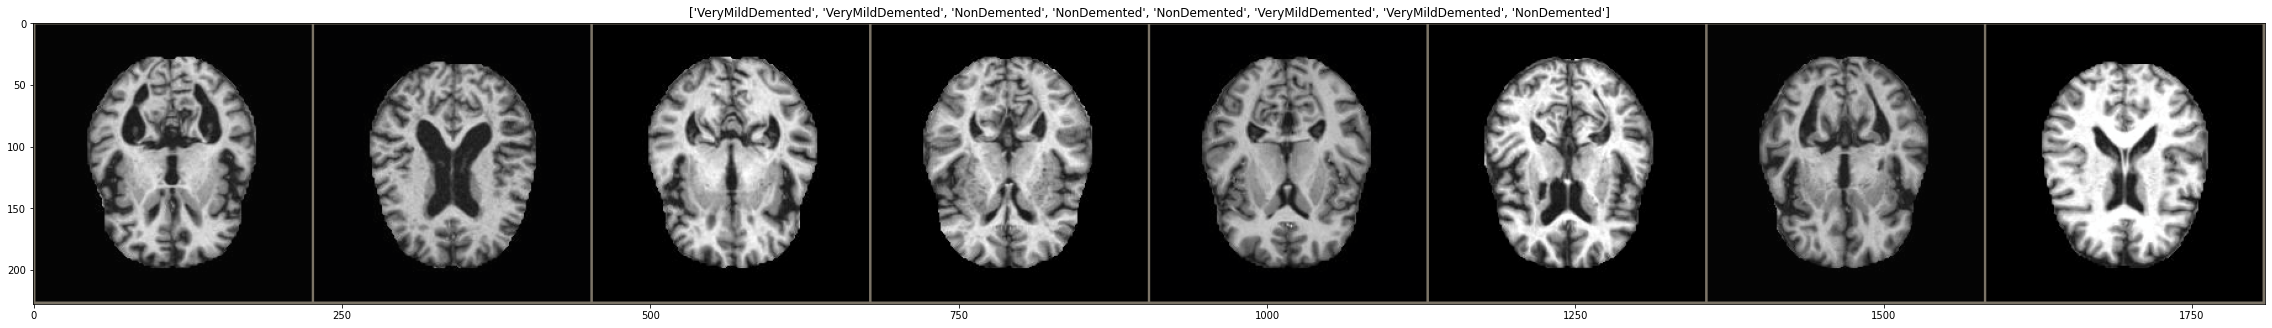

In [11]:
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'val']}
class_names = img_datasets['train'].classes
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(40,40))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
import time

def train_model(model, trainloader, valloader, optimizer, criterion, scheduler, output_dir, name, n_epochs=10):
  path = Path('/content/drive/MyDrive/AlzheimerDetection/'+output_dir)
  path.mkdir(parents=True, exist_ok=True)

  starttime = time.time()

  best_acc = 0.0

  for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}/{n_epochs}")

    model.train()
    running_loss = 0
    running_corrects = 0
    totals = 0

    val_loss = 0
    val_corrects = 0
    val_totals = 0

    for input,labels in trainloader:
      input,labels = input.to(device), labels.to(device)

      optimizer.zero_grad()
      output = model(input)
      _, prediction = torch.max(output, 1)
      running_corrects += torch.sum(prediction == labels.data)
      loss = criterion(output, labels)
      running_loss += loss.item() * input.size(0)
      totals += labels.size(0)
      loss.backward()
      optimizer.step()
      scheduler.step()

    print('Training | Loss: {}  Accuracy: {}\n'.format(running_loss/totals, running_corrects.double()/totals))

    for input,labels in valloader:
      input,labels = input.to(device), labels.to(device)
      model.eval()
      with torch.no_grad():
        output = model(input)
      _, pred = torch.max(output,1)
      val_corrects += torch.sum(pred==labels.data)
      loss = criterion(output,labels)
      val_loss += loss.item() * labels.size(0)
      val_totals += labels.size(0)

    epoch_acc = val_corrects.double()/val_totals
    print("Validation | Loss: {}  Accuracy: {}\n".format(val_loss/val_totals, epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_path = path/f'{name}_{epoch_acc}_{epoch}.h5'
      torch.save(model.state_dict(), best_path)

  timer = time.time() - starttime
  print('Training time: {:.0f}m {:0.0f}s'.format(timer//60, timer/60))
  model.load_state_dict(torch.load(best_path))

  return model


In [14]:
import copy, time
from tqdm import tqdm
def train_model2(model, criterion, optimizer, scheduler, name, num_epochs=25):

    #Creating a folder to save the model performance.
    try:
        path = Path('/content/drive/MyDrive/AlzheimerDetection/modelPerformance') /f'{name}'
        path.mkdir(parents=True, exist_ok=True)
    except:
        print('Couldnt create directory')

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            #epochs
            
            epoch=int(len(img_datasets[phase])/BATCH_SIZE)
            
            for _ in tqdm(range(epoch)):
                #Loading Data
                
                inputs, labels = next(iter(dataloaders[phase]))
                
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.to(device)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #AUC: {:.4f} , epoch_auc
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(        
                phase, epoch_loss, epoch_acc))
    
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                bestpath = path / f'{epoch_acc}_{epoch}.h5'
                torch.save(model,bestpath)

                train_losses = []
                valid_losses = []

        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    with open(f'./modelPerformance/{name}/'+sorted(os.listdir(f'./modelPerformance/{name}/'))[-1], 'rb') as f:
        buffer = io.BytesIO(f.read())
    model=torch.load(buffer)
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
from torchvision.models import vgg19, VGG19_Weights

model = vgg19(weights=VGG19_Weights.DEFAULT)

for params in model.features.parameters():
  params.requires_grad = False

model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [16]:

model_ftrs = model.classifier[6].in_features

model.classifier[6] = nn.Sequential(nn.Linear(model_ftrs, len(class_names)), nn.Softmax())

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model_ft = train_model2(model,criterion, optimizer, lr_sched, "Model2")

Epoch 1/25
----------


  0%|          | 0/511 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 511/511 [08:05<00:00,  1.05it/s]


train Loss: 1.2443 Acc: 0.4962


100%|██████████| 127/127 [01:48<00:00,  1.17it/s]


val Loss: 1.2557 Acc: 0.4761

Epoch 2/25
----------


100%|██████████| 511/511 [12:34<00:00,  1.48s/it]


train Loss: 1.2511 Acc: 0.4896


100%|██████████| 127/127 [03:09<00:00,  1.49s/it]


val Loss: 1.2215 Acc: 0.5103

Epoch 3/25
----------


100%|██████████| 511/511 [13:48<00:00,  1.62s/it]


train Loss: 1.2491 Acc: 0.4916


100%|██████████| 127/127 [03:11<00:00,  1.51s/it]


val Loss: 1.2508 Acc: 0.4809

Epoch 4/25
----------


100%|██████████| 511/511 [14:32<00:00,  1.71s/it]


train Loss: 1.2518 Acc: 0.4889


100%|██████████| 127/127 [03:22<00:00,  1.60s/it]


val Loss: 1.2185 Acc: 0.5132

Epoch 5/25
----------


  8%|▊         | 39/511 [01:20<16:04,  2.04s/it]

In [17]:
model_ft = train_model(model, dataloaders['train'], dataloaders['val'], optimizer, criterion, lr_sched,'Model', name='AlzDetector',
                            n_epochs=EPOCH)

Epoch: 1/5


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training | Loss: 1.2265730497746823  Accuracy: 0.4976800976800977

Validation | Loss: 1.2242643485903624  Accuracy: 0.5004887585532747

Epoch: 2/5
Training | Loss: 1.2220174348689115  Accuracy: 0.5035409035409035

Validation | Loss: 1.2242643572135172  Accuracy: 0.5004887585532747

Epoch: 3/5
Training | Loss: 1.2253466382859246  Accuracy: 0.5006105006105006

Validation | Loss: 1.2242643525523524  Accuracy: 0.5004887585532747

Epoch: 4/5
Training | Loss: 1.2247195009783511  Accuracy: 0.5001221001221001

Validation | Loss: 1.2242643461432507  Accuracy: 0.5004887585532747

Epoch: 5/5
Training | Loss: 1.2225909003990183  Accuracy: 0.5025641025641026

Validation | Loss: 1.2242643495225953  Accuracy: 0.5004887585532747

Training time: 5m 6s
